# Ανάλυση Κατασκεύων σε Η/Υ - Άσκηση 4 (Απρ.2021)

In [1]:
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
from tabulate import tabulate
from IPython.display import display, Markdown

In [2]:
class ElementForces:
    
    def __init__(self):
        self.element = None        # int
        self.eleforce = None       # list
        self.load_pattern = None   # str
        self.element_type = None   # 'beam' or 'col'
        self.time_step = 0         # int
        
        self._Mi = None
        self._Mj = None
        self._Vi = None
        self._Vj = None
        self._Ni = None
        self._Nj = None
        
    @classmethod
    def from_opensees_eleforce(cls, element, eleforce, load_pattern, element_type='beam', time_step=0):
        #     - Στύλοι:
        # >-Vi, -Ni, Mi, Vj, Nj, -Mj

        # - Δοκοί:
        # >-Ni, -Vi, -Mi, Nj, Vj, Mj

        ef = cls()
        ef.element = element
        ef.eleforce = eleforce
        ef.load_pattern = load_pattern
        ef.element_type = element_type
        
        if element_type=='beam':
            ef._Mi = -eleforce[2]
            ef._Mj = eleforce[5]
            ef._Vi = -eleforce[1]
            ef._Vj = eleforce[4]
            ef._Ni = -eleforce[0]
            ef._Nj = eleforce[3]
        else:
            ef._Mi = eleforce[2]
            ef._Mj = -eleforce[5]
            ef._Vi = -eleforce[0]
            ef._Vj = eleforce[3]
            ef._Ni = -eleforce[1]
            ef._Nj = eleforce[4]
        
        return ef
      
    @property
    def Mi(self):
        return self._Mi
 
    @property
    def Mj(self):
        return self._Mj

    @property
    def Vi(self):
        return self._Vi
 
    @property
    def Vj(self):
        return self._Vj
        
    @property
    def Ni(self):
        return self._Ni
 
    @property
    def Nj(self):
        return self._Nj
    
    @property
    def row(self):
        return [self.load_pattern, self.element, self.element_type, self.time_step, self.Ni, self.Vi, self.Mi, self.Nj, self.Vj, self.Mj]

## Εισαγωγή αριθμού μητρώου φοιτητών

Αντικαταστήστε τα ψηφία με αυτά του αριθμού μητρώου σας και τρέξτε το jupyter notebook.  
Δε θα χρειαστεί να κάνετε κάποια άλλη αλλαγή ή κάποια εισαγωγή δεδομένων

In [3]:
κ, λ, μ, ν = 9, 8, 7, 6

## Δεδομένα

In [4]:
E=2.8*10**7
U = 0.0

# Δεδομένα φοιτητών βάσει ΑΕΜ
H=2.7+0.1*(λ+μ)
L=4.5+0.1*(κ+ν)
if ν<5:
    bc=hc=0.45
    bw=0.25
    h=0.65
    hf=0.20
    beff=1.40
else:
    bc=hc=0.50
    bw=0.30
    h=0.70
    hf=0.20
    beff=1.50
bwall=0.25
Lwall=1.7+0.1*ν

F=900.+10*μ+ν
G=15.+λ+ν
Q=8.+ν
   
# # # Δεδομένα παραδείγματος βιβλίου
# H=3.0
# L=5.0
# bc=hc=0.4
# bw=0.25
# h=0.70
# hf=0.15
# beff=1.20
# bwall = 0.25
# Lwall = 2.0

# F=1000.
# G=20.
# Q=10.

In [5]:
print(f'H = {H:.2f}m')
print(f'L = {L:.2f}m')
print(f'bc = hc = {bc:.2f}m')
print(f'bw = {bw:.2f}m')
print(f'h = {h:.2f}m')
print(f'hf = {hf:.2f}m')
print(f'beff = {beff:.2f}m')
print(f'bwall = {bwall:.2f}m')
print(f'Lwall = {Lwall:.2f}m')

print(f'E = {F:.2f}kN')
print(f'G = {G:.2f}kN/m')
print(f'Q = {Q:.2f}kN/m')

H = 4.20m
L = 6.00m
bc = hc = 0.50m
bw = 0.30m
h = 0.70m
hf = 0.20m
beff = 1.50m
bwall = 0.25m
Lwall = 2.30m
E = 976.00kN
G = 29.00kN/m
Q = 14.00kN/m


## Επίλυση με το OpenSees

In [6]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

U = 0.0
G_shear = E / (2.0*(1.0+U))

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

wall =  RectangularSectionGeometry(b=bwall, h=Lwall)
A_wall = wall.area
Iz_wall = wall.moment_of_inertia_xx * 0.5
Avy_wall = wall.shear_area_2 * 0.5

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, 0., H)
ops.node(3, L, 0.)
ops.node(4, L, H)
ops.node(5, 2*L, 0.)
ops.node(6, 2*L, H)
ops.node(7, L-Lwall/2., H)
ops.node(8, L+Lwall/2., H)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)
ops.fix(5, 1, 1, 1)

ops.equalDOF(4, 2, 1)
ops.equalDOF(6, 2, 1)
    
ops.geomTransf('Linear', 1)

# Στύλοι
ops.element('ElasticTimoshenkoBeam', 1, 1, 2, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 5, 6, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')

# Τοίχωμα
ops.element('ElasticTimoshenkoBeam', 3, 3, 4, E, G_shear, A_wall, Iz_wall, Avy_wall, 1)  # , '-mass', 0., '-lMass')

# Δοκοί
ops.element('ElasticTimoshenkoBeam', 4, 2, 7, E, G_shear, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 5, 8, 6, E, G_shear, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

# Βραχίονες
ops.element('ElasticTimoshenkoBeam', 6, 7, 4, E, G_shear, 100., 100., 100., 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 7, 4, 8, E, G_shear, 100., 100., 100., 1)  # , '-mass', 0., '-lMass')

results_ele = []
results_node = []

# F Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.load(2, F, 0., 0.)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
#     results_ele.append(['F', el_num, ops.eleForce(el_num)])
    if el_num<=3: 
        el_type='col'
    else:
        el_type='beam'
    results_ele.append(ElementForces.from_opensees_eleforce(element=el_num,
                           eleforce=ops.eleForce(el_num),
                           load_pattern='F',
                           element_type=el_type,
                           time_step=0))
results_node.append(['F', ops.nodeDisp(2)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# G Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -G)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -G)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
#     results_ele.append(['G', el_num, ops.eleForce(el_num)])
    if el_num<=3: 
        el_type='col'
    else:
        el_type='beam'
    results_ele.append(ElementForces.from_opensees_eleforce(element=el_num,
                           eleforce=ops.eleForce(el_num),
                           load_pattern='G',
                           element_type=el_type,
                           time_step=0))
results_node.append(['G', ops.nodeDisp(2)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# Q Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 4, '-type', '-beamUniform', -Q)
ops.eleLoad('-ele', 5, '-type', '-beamUniform', -Q)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(7):
    el_num=i+1
#     results_ele.append(['Q', el_num, ops.eleForce(el_num)])
    if el_num<=3: 
        el_type='col'
    else:
        el_type='beam'
    results_ele.append(ElementForces.from_opensees_eleforce(element=el_num,
                           eleforce=ops.eleForce(el_num),
                           load_pattern='Q',
                           element_type=el_type,
                           time_step=0))
results_node.append(['Q', ops.nodeDisp(2)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()



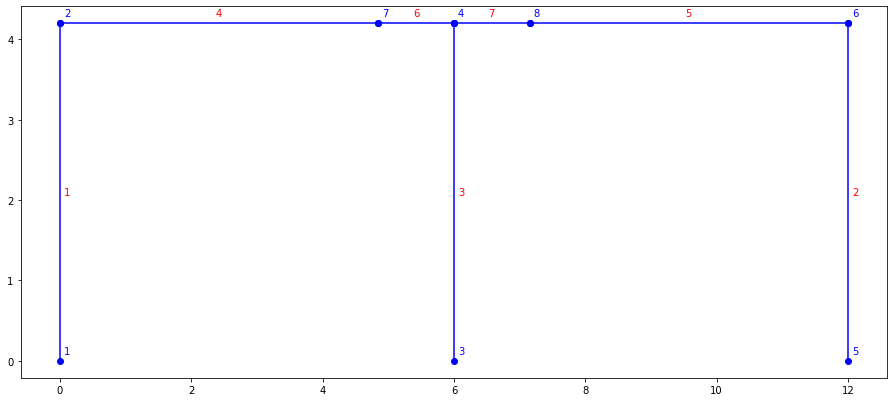

In [7]:
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(left=.08, bottom=.08, right=.94, top=.94)
ax1 = plt.subplot(111)

opsv.plot_model()

## Εμφάνιση αποτελεσμάτων

In [8]:
for re in results_ele:
#     print(re.load_pattern, re.element, re.element_type, round(re.Mi,2))
    print(re.row)

['F', 1, 'col', 0, 85.01351183449798, 63.74840155726437, 130.04919498368335, 85.01351183449798, 63.74840155726437, -137.694091556827]
['F', 2, 'col', 0, -84.88591276725742, 63.52673243202453, 129.5417646696735, -84.88591276725742, 63.52673243202453, -137.2705115448295]
['F', 3, 'col', 0, -0.12759906742074964, 848.7248660063277, 2820.2124927163127, -0.12759906742074964, 848.7248660063277, -744.4319445102637]
['F', 4, 'beam', 0, -1.8189894035458565e-12, 85.01351183449798, 137.694091556827, -1.8189894035458565e-12, 85.01351183449798, -274.62144084048816]
['F', 5, 'beam', 0, -63.52673243202298, 84.88591276725744, 274.42616537636906, -63.52673243202298, 84.88591276725744, -137.2705115448295]
['F', 6, 'beam', 0, 1.862645149230957e-09, 85.0135118344333, -274.62144084088504, 1.862645149230957e-09, 85.0135118344333, -372.38697945000604]
['F', 7, 'beam', 0, -63.52673243358731, 84.88591276702937, 372.0449650590308, -63.52673243358731, 84.88591276702937, 274.4261653763242]
['G', 1, 'col', 0, -57.9

### Εντατικά μεγέθη για κάθε load pattern

In [9]:
table = []
for re in results_ele:
    row = [re.load_pattern, re.element]
    row.extend(re.row[4:])
#     row.extend([i for i in re[2]])
    table.append(row)
print(tabulate(table, headers=["Φόρτιση", "Στοιχείο", 'Ni', 'Vi', 'Mi', 'Nj', 'Vj', 'Mj'], floatfmt=".2f", tablefmt='pipe'))

| Φόρτιση   |   Στοιχείο |      Ni |     Vi |      Mi |      Nj |     Vj |      Mj |
|:----------|-----------:|--------:|-------:|--------:|--------:|-------:|--------:|
| F         |          1 |   85.01 |  63.75 |  130.05 |   85.01 |  63.75 | -137.69 |
| F         |          2 |  -84.89 |  63.53 |  129.54 |  -84.89 |  63.53 | -137.27 |
| F         |          3 |   -0.13 | 848.72 | 2820.21 |   -0.13 | 848.72 | -744.43 |
| F         |          4 |   -0.00 |  85.01 |  137.69 |   -0.00 |  85.01 | -274.62 |
| F         |          5 |  -63.53 |  84.89 |  274.43 |  -63.53 |  84.89 | -137.27 |
| F         |          6 |    0.00 |  85.01 | -274.62 |    0.00 |  85.01 | -372.39 |
| F         |          7 |  -63.53 |  84.89 |  372.04 |  -63.53 |  84.89 |  274.43 |
| G         |          1 |  -57.91 |  -5.58 |   -7.68 |  -57.91 |  -5.58 |   15.75 |
| G         |          2 |  -57.91 |   5.56 |    7.64 |  -57.91 |   5.56 |  -15.72 |
| G         |          3 | -165.48 |   0.02 |    0.07 | -165.48 |

In [10]:
df = pd.DataFrame(table, columns=["Φόρτιση", "Στοιχείο", 'Ni', 'Vi', 'Mi', 'Nj', 'Vj', 'Mj'])
df.style.set_precision(2)

,Φόρτιση,Στοιχείο,Ni,Vi,Mi,Nj,Vj,Mj
0,F,1,85.01,63.75,130.05,85.01,63.75,-137.69
1,F,2,-84.89,63.53,129.54,-84.89,63.53,-137.27
2,F,3,-0.13,848.72,2820.21,-0.13,848.72,-744.43
3,F,4,-0.00,85.01,137.69,-0.00,85.01,-274.62
4,F,5,-63.53,84.89,274.43,-63.53,84.89,-137.27
5,F,6,0.00,85.01,-274.62,0.00,85.01,-372.39
6,F,7,-63.53,84.89,372.04,-63.53,84.89,274.43
7,G,1,-57.91,-5.58,-7.68,-57.91,-5.58,15.75
8,G,2,-57.91,5.56,7.64,-57.91,5.56,-15.72
9,G,3,-165.48,0.02,0.07,-165.48,0.02,0.00


In [11]:
cases_groups = df.groupby('Φόρτιση')
cases_groups.get_group("F").style.set_precision(2)

,Φόρτιση,Στοιχείο,Ni,Vi,Mi,Nj,Vj,Mj
0,F,1,85.01,63.75,130.05,85.01,63.75,-137.69
1,F,2,-84.89,63.53,129.54,-84.89,63.53,-137.27
2,F,3,-0.13,848.72,2820.21,-0.13,848.72,-744.43
3,F,4,-0.00,85.01,137.69,-0.00,85.01,-274.62
4,F,5,-63.53,84.89,274.43,-63.53,84.89,-137.27
5,F,6,0.00,85.01,-274.62,0.00,85.01,-372.39
6,F,7,-63.53,84.89,372.04,-63.53,84.89,274.43


In [12]:
results_gravity = 1.35*cases_groups.get_group("G").set_index('Στοιχείο').drop(columns=['Φόρτιση'])+ \
                  1.50*cases_groups.get_group("Q").set_index('Στοιχείο').drop(columns=['Φόρτιση'])

results_gravity.style.set_precision(2)

,Ni,Vi,Mi,Nj,Vj,Mj
Στοιχείο,,,,,,
1,-120.12,-11.57,-15.92,-120.12,-11.57,32.67
2,-120.11,11.54,15.84,-120.11,11.54,-32.61
3,-343.22,0.03,0.15,-343.22,0.03,0.01
4,-0.00,-120.12,-32.67,-0.00,171.61,-157.52
5,-11.54,-171.62,-157.52,-11.54,120.11,-32.61
6,0.00,171.61,-157.52,0.00,171.61,-354.87
7,-11.54,-171.62,-354.88,-11.54,-171.62,-157.52


In [13]:
results_seismic = 1.0*cases_groups.get_group("G").set_index('Στοιχείο').drop(columns=['Φόρτιση'])+ \
                  0.3*cases_groups.get_group("Q").set_index('Στοιχείο').drop(columns=['Φόρτιση'])+ \
                  1.0*cases_groups.get_group("F").set_index('Στοιχείο').drop(columns=['Φόρτιση'])

results_seismic.style.set_precision(2)

,Ni,Vi,Mi,Nj,Vj,Mj
Στοιχείο,,,,,,
1,18.71,57.36,121.26,18.71,57.36,-119.66
2,-151.18,69.89,138.29,-151.18,69.89,-155.27
3,-189.57,848.74,2820.29,-189.57,848.74,-744.43
4,-0.00,18.71,119.66,-0.00,179.73,-361.57
5,-69.89,-9.84,187.48,-69.89,151.18,-155.27
6,0.00,179.73,-361.57,0.00,179.73,-568.26
7,-69.89,-9.84,176.17,-69.89,-9.84,187.48


### Αποτελέσματα εντατικών μεγεθών για τα ζητούμενα της εκφώνησης
(μάλλον θα υπάρχουν μικρές αποκλίσεις στα δεκαδικά)

In [14]:
print('Για 1.35G+1.5Q')
print(f"M_αριστ_στύλος_βάση= {results_gravity['Mi'][1]:.2f}kNm")
print(f"M_τοιχ_βάση= {results_gravity['Mi'][3]:.2f}kNm")
print(f"M_δεξ_στύλος_βάση= {results_gravity['Mi'][2]:.2f}kNm")
print(f"M_αριστ_δοκός_αρχή= {results_gravity['Mi'][4]:.2f}kNm")
print(f"M_αριστ_δοκός_τέλος= {results_gravity['Mj'][4]:.2f}kNm")
print(f"M_δεξ_δοκός_αρχή= {results_gravity['Mi'][5]:.2f}kNm")
print(f"M_δεξ_δοκός_τέλος= {results_gravity['Mj'][5]:.2f}kNm")
print()
print('Για G+0.3Q+E')
print(f"M_αριστ_στύλος_βάση= {results_seismic['Mi'][1]:.2f}kNm")
print(f"M_τοιχ_βάση= {results_seismic['Mi'][3]:.2f}kNm")
print(f"M_δεξ_στύλος_βάση= {results_seismic['Mi'][2]:.2f}kNm")
print(f"M_αριστ_δοκός_αρχή= {results_seismic['Mi'][4]:.2f}kNm")
print(f"M_αριστ_δοκός_τέλος= {results_seismic['Mj'][4]:.2f}kNm")
print(f"M_δεξ_δοκός_αρχή= {results_seismic['Mi'][5]:.2f}kNm")
print(f"M_δεξ_δοκός_τέλος= {results_seismic['Mj'][5]:.2f}kNm")

Για 1.35G+1.5Q
M_αριστ_στύλος_βάση= -15.92kNm
M_τοιχ_βάση= 0.15kNm
M_δεξ_στύλος_βάση= 15.84kNm
M_αριστ_δοκός_αρχή= -32.67kNm
M_αριστ_δοκός_τέλος= -157.52kNm
M_δεξ_δοκός_αρχή= -157.52kNm
M_δεξ_δοκός_τέλος= -32.61kNm

Για G+0.3Q+E
M_αριστ_στύλος_βάση= 121.26kNm
M_τοιχ_βάση= 2820.29kNm
M_δεξ_στύλος_βάση= 138.29kNm
M_αριστ_δοκός_αρχή= 119.66kNm
M_αριστ_δοκός_τέλος= -361.57kNm
M_δεξ_δοκός_αρχή= 187.48kNm
M_δεξ_δοκός_τέλος= -155.27kNm


### Μετακινήσεις για τα load patterns

In [15]:
for re in results_node:
    print(f'Για φόρτιση {re[0]}: δ={1000*re[1][0]:.2f}mm')

Για φόρτιση F: δ=5.12mm
Για φόρτιση G: δ=0.00mm
Για φόρτιση Q: δ=0.00mm


In [16]:
for re in results_node:
    print(re)

['F', [0.005118936708397882, 5.100810710069879e-05, 0.0002201730213065375]]
['G', [1.3995197960942063e-07, -3.474831816964677e-05, -0.0002326284591142837]]
['Q', [6.75630127873967e-08, -1.677505015098826e-05, -0.00011230339405581162]]


### Αποτελέσματα μετακινήσεων για τα ζητούμενα της εκφώνησης

In [17]:
print('Για 1.35G+1.5Q')
print(f'δ=0.0cm')
print()
print('Για G+0.3Q+E')
print(f'δ={(1000*results_node[0][1][0]):.2f}mm')

Για 1.35G+1.5Q
δ=0.0cm

Για G+0.3Q+E
δ=5.12mm
